# Clustering SQL Developers - Stack Overflow Survey 2016

Every year, Stack Overflow runs a survey asking developers about their work and the technologies they use. In the 2016 iteration, more than 50,000 developers completed the survey. I wasn't able to find any detailed analyses using the raw data ([http://stackoverflow.com/research](http://stackoverflow.com/research)), so I decided to play around with the dataset to see if there are any interesting patterns -- particularly relating to usage of SQL Server and other RDBMS. 

Let's define a **"SQL developer"** as a Stack Overflow 2016 Survey respondent who indicated they **'did extensive development work' in "SQL" or "SQL Server" in the past year.**

This notebook looks at three questions:

1. Can SQL developers be clustered into distinct groups based on their reported characteristics? (region, age, occupation, experience, technologies, dev environment, desktop OS) 

2. Which characteristics are most associated with SQL Server?

3. What is SQL Server's "developer share" across various technologies?

I'm particularly curious to see how these statistics shift over the next few years, in light of the introduction of [SQL Server on Linux](https://www.microsoft.com/en-us/sql-server/sql-server-vnext-including-Linux). 

*CAVEAT: This analysis assumes that survey respondents understood 'SQL Server' to mean Microsoft's SQL Server, and 'SQL' to mean any other RDBMS. To the extent that respondents conflated these two terms, these numbers will be biased.*

## Data preparation

Of the 43,007 developers who reported the characteristics listed above, 21,675 (50.5%) are SQL developers.

In [8]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [9]:
# Load Stack Overflow survey raw data
# Download here: http://stackoverflow.com/research
df = pd.read_csv('2016 Stack Overflow Survey Responses.csv')

In [10]:
# Fill in job cells for students so we don't drop them as empty
df['company_size_range'] = df.apply(lambda row: 
                                    'student' if row['employment_status'] == 'I\'m a student' 
                                    else row['company_size_range'], axis=1)

In [11]:
# Grab the features we'll use for clustering
clean_df = df[['un_subregion', 'age_range', 'occupation', 
               'experience_range', 'tech_do', 'company_size_range', 
               'dev_environment', 'desktop_os']].dropna().reset_index().drop('index', 1)

region_options = list(set(clean_df['un_subregion']))
age_range_options = list(set(clean_df['age_range']))
occupation_options = list(set(clean_df['occupation']))
experience_range_options = list(set(clean_df['experience_range']))
tech_options = list(set(';'.join(clean_df['tech_do']).replace('; ', ';').split(';')))
company_size_range_options = list(set(clean_df['company_size_range']))
dev_environment_options = list(set(';'.join(clean_df['dev_environment']).replace('; ', ';').split(';')))
desktop_os_options = list(set(clean_df['desktop_os']))

key = region_options + age_range_options + occupation_options + \
    experience_range_options + tech_options + company_size_range_options + \
    dev_environment_options + desktop_os_options

In [12]:
# Annotate the features for readability later
key_annotated = []
for k in key:
    if k in region_options:
        key_annotated.append('{0}'.format(k))
    elif k in age_range_options:
        key_annotated.append('{0} (age)'.format(k))
    elif k in occupation_options:
        key_annotated.append('{0} (occupation)'.format(k))
    elif k in experience_range_options:
        key_annotated.append('{0} (experience)'.format(k))
    elif k in tech_options:
        key_annotated.append('{0}'.format(k))
    elif k in company_size_range_options:
        key_annotated.append('{0} (company size)'.format(k))
    elif k in dev_environment_options:
        key_annotated.append('{0}'.format(k))
    elif k in desktop_os_options:
        key_annotated.append('{0}'.format(k))

# Sanity check
assert(len(key_annotated) == len(key))

In [13]:
# Convert each response into a binary feature matrix
dataset = np.zeros([len(clean_df), len(key)])
for i, response in clean_df.iterrows():
    for k in ';'.join(response).replace('; ', ';').split(';'):
        dataset[i, key.index(k)] = 1
print('Dataset shape:', dataset.shape)

Dataset shape: (43007, 150)


In [14]:
# Remove all developers who don't use either 'SQL' or 'SQL Server'
idx_sql = key.index('SQL')
idx_sqlserver = key.index('SQL Server')
sql_pop = np.where(dataset[:,idx_sql] + dataset[:,idx_sqlserver] > 0)[0]
dataset_sql = dataset[sql_pop,:]
print('Developers overall:', dataset.shape[0])
print('Developers using an RDBMS: {0} ({1:.1f}%)'.format(dataset_sql.shape[0], 
                                                         100.0 * dataset_sql.shape[0] / dataset.shape[0]))

Developers overall: 43007
Developers using an RDBMS: 21675 (50.4%)


## Can developers be clustered into distinct groups?

Let's use k-means to cluster SQL developers based on the characteristics above. I picked k=10 clusters arbitrarily after trying a few different values, and finding that this value results in reasonable-looking clusters with distinctive characteristics. 

It's interesting to look at which clusters tend to over lap, versus those that are far apart. 

If we use [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA) to reduce the dimensionality of our dataset, we can plot each SQL developer on a 2D graph and color by cluster. 

In [19]:
# Cluster using k-means (takes a few seconds)
# Note it's not deterministic
n_clusters = 10
est = KMeans(n_clusters=n_clusters)
est.fit(dataset_sql)
clusters = est.predict(dataset_sql)

In [20]:
# For each cluster, print the mean (centroid) characteristics shared by more than 50% of its members
threshold = 0.5
cluster_desc = []
for c in range(n_clusters):
    desc = ''
    indexes = np.where(clusters == c)[0]
    print('Cluster {0} (n={1}):'.format(c, len(indexes)))
    print('-------------------')
    means = dataset_sql[indexes].mean(axis=0)
    key_features = np.where(means > threshold)[0]
    for f in key_features:
        print('{0:.2f} {1}'.format(means[f], key_annotated[f]))
        desc += key_annotated[f] + ', '
    desc = desc[:-2]
    if c < n_clusters - 1:
        print('')
    cluster_desc.append(desc)

Cluster 0 (n=1179):
-------------------
0.89 iOS
0.62 Android
0.65 Java
0.80 JavaScript
0.66 Objective-C
0.97 SQL
0.58 PHP
0.54 Swift
0.82 Xcode
0.70 Mac OS X

Cluster 1 (n=2817):
-------------------
0.76 2 - 5 years (experience)
0.70 JavaScript
0.77 SQL Server
0.76 SQL
0.94 C#
0.60 Notepad++
0.97 Visual Studio

Cluster 2 (n=3010):
-------------------
1.00 11+ years (experience)
0.68 JavaScript
0.82 SQL Server
0.78 SQL
0.92 C#
0.57 Notepad++
0.97 Visual Studio

Cluster 3 (n=1529):
-------------------
0.99 6 - 10 years (experience)
0.67 JavaScript
0.99 SQL
0.57 Vim

Cluster 4 (n=2217):
-------------------
0.88 Java
0.55 JavaScript
0.97 SQL
0.77 Notepad++
0.75 Eclipse
0.56 Windows 7

Cluster 5 (n=1872):
-------------------
0.78 2 - 5 years (experience)
0.65 JavaScript
0.98 SQL
0.52 Python
0.52 Vim
0.53 Sublime

Cluster 6 (n=1979):
-------------------
0.60 20-24 (age)
0.65 Student (occupation)
0.77 Java
0.59 JavaScript
0.97 SQL
0.60 PHP
0.75 student (company size)
0.50 Notepad++

Cluster 

In [21]:
# Try PCA down to 2-dimensions to visualize
pca = PCA(n_components=2, ).fit_transform(dataset_sql)

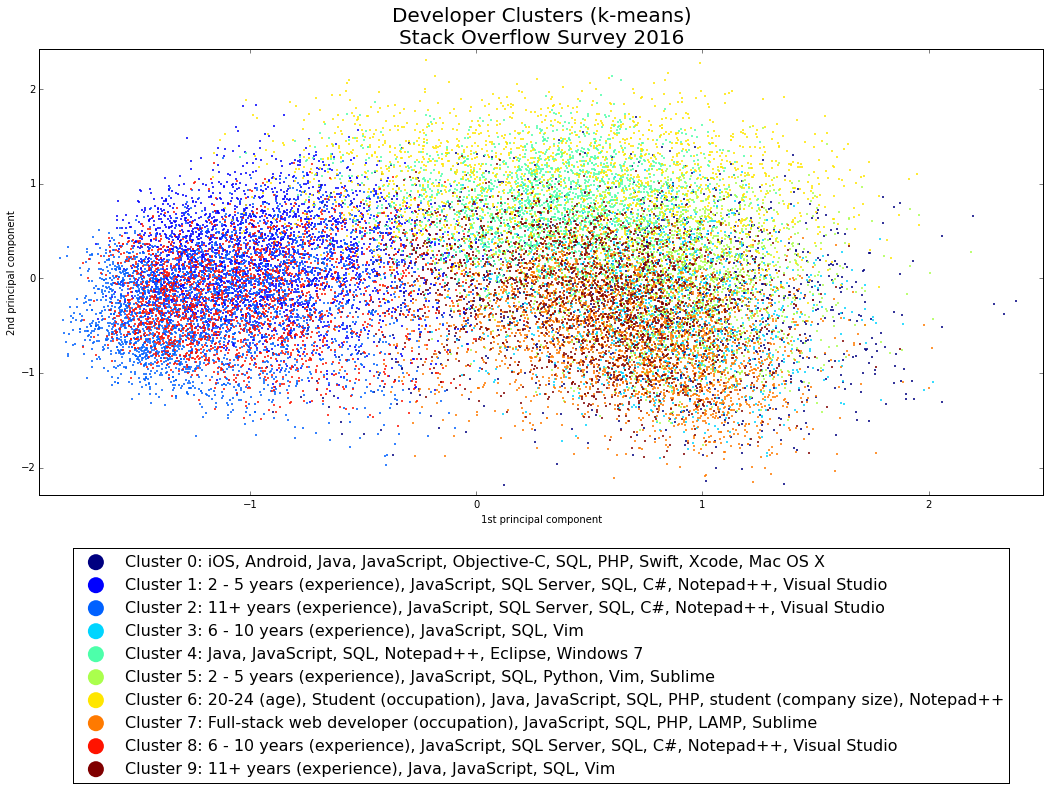

In [22]:
# Scatter plot the first 2 principal components, colored by cluster type
plt.figure(figsize=[18, 8])
plt.title('Developer Clusters (k-means)\nStack Overflow Survey 2016', fontsize=20)
color_list = plt.cm.jet(np.linspace(0, 1, n_clusters))
for i in range(n_clusters):
    indexes = np.where(clusters == i)[0]
    plt.scatter(pca[indexes,0], pca[indexes,1], c=color_list[i], 
                s=4, linewidths=0, label='Cluster {0}: {1}'.format(i, cluster_desc[i]))
plt.xlabel('1st principal component')
plt.ylabel('2nd principal component')
margin = 1.05
plt.xlim(margin * pca[:,0].min(), margin * pca[:,0].max())
plt.ylim(margin * pca[:,1].min(), margin * pca[:,1].max())

plt.legend(markerscale=8, fontsize=16, scatterpoints=1, loc=9, bbox_to_anchor=(0.5, -0.1))
plt.show()

## Which types of developers use RDBMS?

There's a clear visual separation between SQL developers who use SQL Server vs. those who use another RDBMS. Comparing with the cluster segmentations above, SQL Server developers heavily overlap with the C#, JavaScript, Visual Studio, and Notepad++ clusters, and are particularly distant from the iOS, Node.js, Sublime, Mac OS X, and student clusters.   

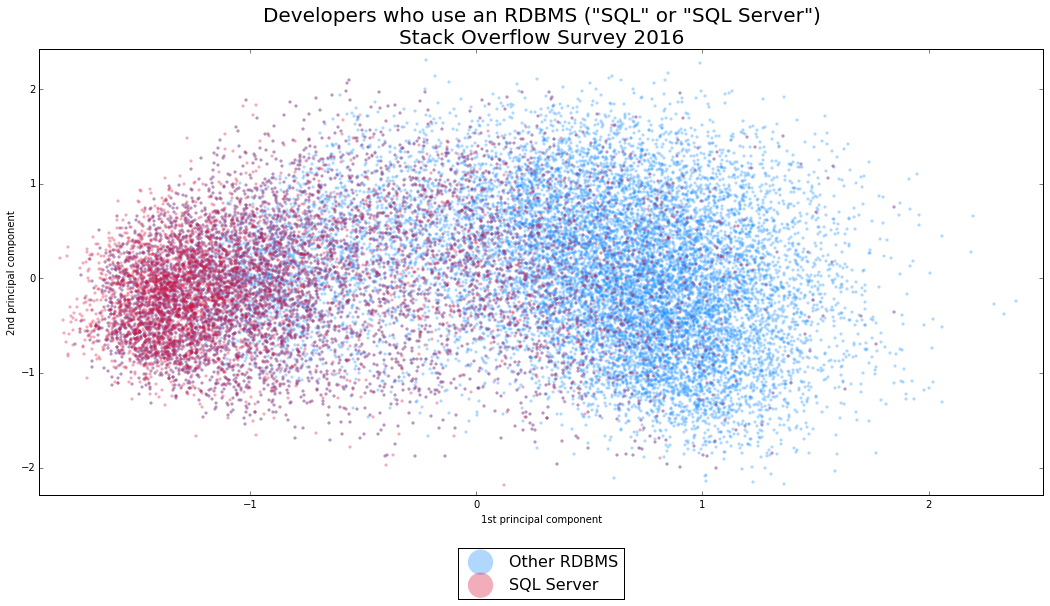

In [24]:
# Scatter plot the first 2 principal components, colored by cluster type
plt.figure(figsize=[18, 8])
plt.title('Developers who use an RDBMS ("SQL" or "SQL Server")\nStack Overflow Survey 2016', fontsize=20)

sql_indexes = np.where(dataset_sql[:,key.index('SQL')] == 1)[0]
plt.scatter(pca[sql_indexes,0], pca[sql_indexes,1], s=10, alpha=0.35, 
            c='dodgerblue', linewidths=0, label='Other RDBMS')

sql_indexes = np.where(dataset_sql[:,key.index('SQL Server')] == 1)[0]
plt.scatter(pca[sql_indexes,0], pca[sql_indexes,1], s=10, alpha=0.35, 
            c='crimson', linewidths=0, label='SQL Server')

plt.xlabel('1st principal component')
plt.ylabel('2nd principal component')
margin = 1.05
plt.xlim(margin * pca[:,0].min(), margin * pca[:,0].max())
plt.ylim(margin * pca[:,1].min(), margin * pca[:,1].max())

plt.legend(markerscale=8, fontsize=16, scatterpoints=1, loc=9, bbox_to_anchor=(0.5, -0.1))
plt.show()

## Which types of developers use SQL Server?
More than 70% of developers who use SQL Server also use:
* Visual Studio
* C#
* JavaScript

In [25]:
# Co-occurrence matrix
# Dot product tells us how many times each feature co-occurs with each other feature
coocc = np.dot(dataset.T, dataset)
diagonal = np.diagonal(coocc)
with np.errstate(divide='ignore', invalid='ignore'):
    coocc_pct = np.nan_to_num(np.true_divide(coocc, diagonal[:, None]))
coocc_pct = pd.DataFrame(coocc_pct)
coocc_pct.columns = key_annotated
coocc_pct.index = key_annotated
coocc_pct.insert(0, 'n', diagonal)

In [27]:
# What characteristics co-occur most often with SQL Server?
coocc_pct.ix['SQL Server'].order(ascending=False)[:20]

n                                        8406.000000
SQL Server                                  1.000000
Visual Studio                               0.802165
C#                                          0.775280
SQL                                         0.756246
JavaScript                                  0.715798
Notepad++                                   0.565073
Full-stack web developer (occupation)       0.427314
Windows 10                                  0.357721
11+ years (experience)                      0.355817
North America                               0.351773
Windows 7                                   0.316322
2 - 5 years (experience)                    0.283607
Java                                        0.277897
25-29 (age)                                 0.274685
Sublime                                     0.250654
6 - 10 years (experience)                   0.243160
AngularJS                                   0.242565
PHP                                         0.

## What is SQL Server's "developer share"?

Overall, a little over a third of SQL developers use SQL Server.

SQL Server has the strongest developer share (>50%) among developers who use SharePoint, F#, Visual Basic, C#, and Salesforce.

In [28]:
# Determine whether each dev is using SQL, SQL Server, or both
dataset_sql = pd.DataFrame(dataset_sql, columns=key)
dataset_sql['sql_only'] = dataset_sql.apply(lambda row: max(0, row['SQL'] - row['SQL Server']), axis=1)
dataset_sql['sqlserver_only'] = dataset_sql.apply(lambda row: max(0, row['SQL Server'] - row['SQL']), axis=1)
dataset_sql['both'] = dataset_sql.apply(lambda row: row['SQL Server'] * row['SQL'], axis=1)
print('Overall share:')
print('--------------')
print('sqlserver_only: {0:d} ({1:.1f}%)'.format(int(dataset_sql['sqlserver_only'].sum()), 
                                                100*dataset_sql['sqlserver_only'].mean()))
print('both: {0:d} ({1:.1f}%)'.format(int(dataset_sql['both'].sum()), 
                                      100*dataset_sql['both'].mean()))
print('sql_only: {0:d} ({1:.1f}%)'.format(int(dataset_sql['sql_only'].sum()), 
                                          100*dataset_sql['sql_only'].mean()))

Overall share:
--------------
sqlserver_only: 2049 (9.5%)
both: 6357 (29.3%)
sql_only: 13269 (61.2%)


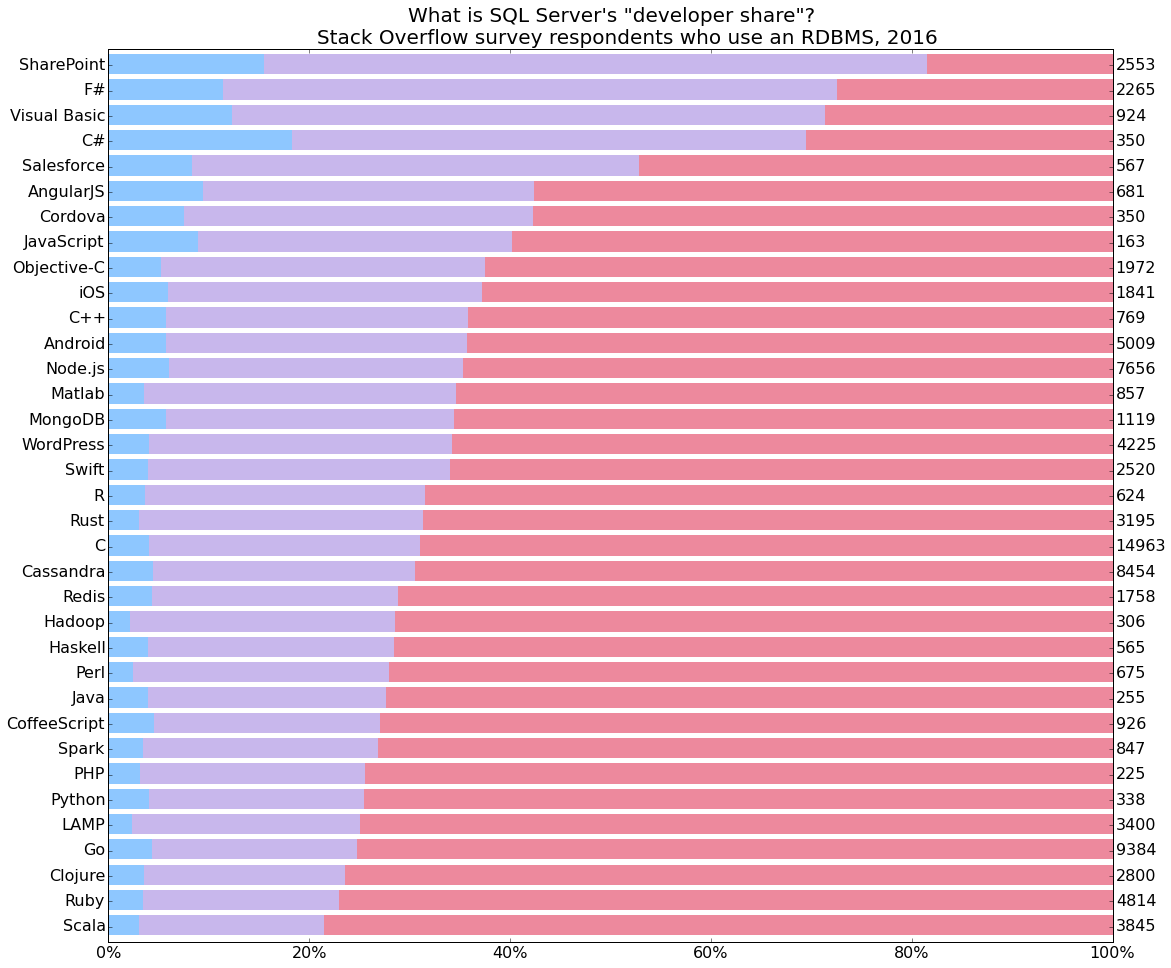

In [29]:
# Plot breakdown of SQL vs. SQL Server vs. both for devs using various technologies
techs = ['Android', 'AngularJS', 'C', 'C#', 'C++', 'Cassandra', 
         'Clojure', 'CoffeeScript', 'Cordova', 'F#', 'Go', 'Hadoop', 
         'Haskell', 'iOS', 'Java', 'JavaScript', 'LAMP', 'Matlab', 
         'MongoDB', 'Node.js', 'Objective-C', 'Perl', 'PHP', 'Python', 
         'R', 'Redis', 'Ruby', 'Rust', 'Salesforce', 'Scala', 'SharePoint', 
         'Spark', 'Swift', 'Visual Basic', 'WordPress']
sql_only = []
sqlserver_only = []
both = []
ns = []
for tech in techs:
    sql_only.append(dataset_sql[dataset_sql[tech] == 1]['sql_only'].mean())
    sqlserver_only.append(dataset_sql[dataset_sql[tech] == 1]['sqlserver_only'].mean())
    both.append(dataset_sql[dataset_sql[tech] == 1]['both'].mean())
    ns.append(len(dataset_sql[dataset_sql[tech] == 1]))

# Sort by sql_only, low to high
zipped = zip(sql_only, both, sqlserver_only, techs)
x = list(zipped)
x.sort(reverse=True)
sql_only, both, sqlserver_only, techs = list(zip(*x))

ys = np.array(range(len(techs)))
xs = ['{0}%'.format(x) for x in (100*np.linspace(0, 1, 6)).astype(int)]

fig, ax = plt.subplots(figsize=(18, 16))
plt.title('What is SQL Server\'s "developer share"?\n \
    Stack Overflow survey respondents who use an RDBMS, 2016', fontsize=20)
plt.barh(ys, sqlserver_only, height=0.8, 
         color='dodgerblue', alpha=0.5, linewidth=0, label='SQL Server only')
plt.barh(ys, both, height=0.8, left=sqlserver_only,
         color='mediumpurple', alpha=0.5, linewidth=0, label='SQL Server + other RDBMS')
plt.barh(ys, sql_only, height=0.8, left=np.array(sqlserver_only)+np.array(both),
         color='crimson', alpha=0.5, linewidth=0, label='Other RDBMS only')

ax.set_yticks(ys+0.35)
ax.set_yticklabels(techs, fontsize=16)
ax.set_xticklabels(xs, fontsize=16)
ax.set_ylim(-0.25, len(techs))
ax.set_xlim(0, 1)

ax2 = ax.twinx()
ax2.set_yticks(ys+0.35)
ax2.set_yticklabels(ns, fontsize=16)
ax2.set_ylim(-0.25, len(techs))

plt.legend(loc='bottom right', fontsize=16)
plt.grid(axis='x')
plt.show()

## What is SQL Server's "developer share" at companies of various sizes?

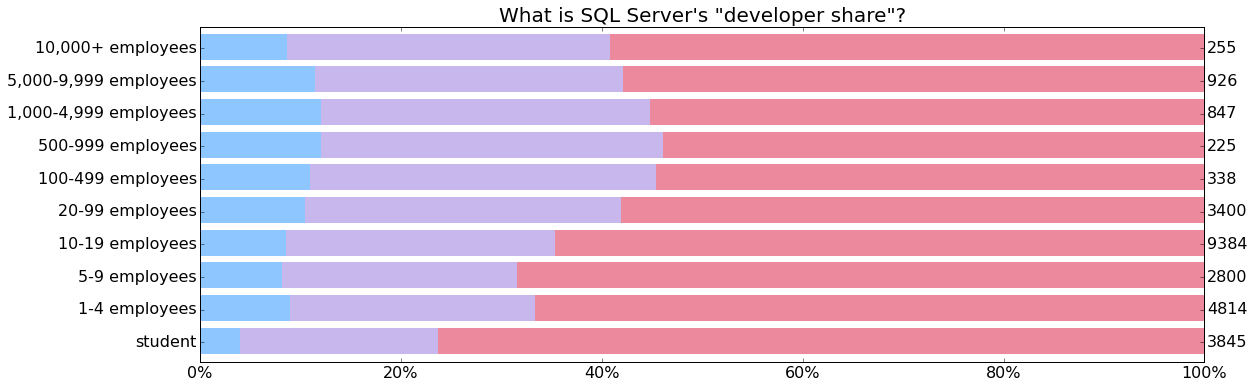

In [31]:
company_sizes = [
    'student',
    '1-4 employees',
    '5-9 employees',
    '10-19 employees',
    '20-99 employees',
    '100-499 employees',
    '500-999 employees',
    '1,000-4,999 employees',
    '5,000-9,999 employees',
    '10,000+ employees'
]

sql_only = []
sqlserver_only = []
both = []
for size in company_sizes:
    sql_only.append(dataset_sql[dataset_sql[size] == 1]['sql_only'].mean())
    sqlserver_only.append(dataset_sql[dataset_sql[size] == 1]['sqlserver_only'].mean())
    both.append(dataset_sql[dataset_sql[size] == 1]['both'].mean())

ys = np.array(range(len(company_sizes)))
xs = ['{0}%'.format(x) for x in (100*np.linspace(0, 1, 6)).astype(int)]

fig, ax = plt.subplots(figsize=(18, 6))
plt.title('What is SQL Server\'s "developer share"?', fontsize=20)
plt.barh(ys, sqlserver_only, height=0.8, 
         color='dodgerblue', alpha=0.5, linewidth=0, label='SQL Server only')
plt.barh(ys, both, height=0.8, left=sqlserver_only,
         color='mediumpurple', alpha=0.5, linewidth=0, label='SQL Server + other RDBMS')
plt.barh(ys, sql_only, height=0.8, left=np.array(sqlserver_only)+np.array(both),
         color='crimson', alpha=0.5, linewidth=0, label='Other RDBMS only')

ax.set_yticks(ys+0.35)
ax.set_yticklabels(company_sizes, fontsize=16)
ax.set_xticklabels(xs, fontsize=16)
ax.set_ylim(-0.25, len(company_sizes))
ax.set_xlim(0, 1)

ax2 = ax.twinx()
ax2.set_yticks(ys+0.35)
ax2.set_yticklabels(ns, fontsize=16)
ax2.set_ylim(-0.25, len(company_sizes))

plt.legend(loc='bottom right', fontsize=16)
plt.grid(axis='x')
plt.show()